In [13]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import KFold
import torch.optim as optim

In [14]:
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
import tqdm

class CatNotCatDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the animal subdirectories.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []

        # Load all image file paths and their labels ('cat' or 'not cat')
        for sub_dir in os.listdir(root_dir):
            class_path = os.path.join(root_dir, sub_dir)
            if os.path.isdir(class_path):
                for img_file in os.listdir(class_path):
                    if img_file.lower().endswith(('png', 'jpg', 'jpeg')):
                        img_path = os.path.join(class_path, img_file)
                        # Label 1 for cat, 0 for not cat
                        label = 1 if sub_dir.lower() == 'cat' else 0
                        self.samples.append((img_path, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        return image, label


In [15]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet normalization
])

dataset = CatNotCatDataset(root_dir='one_vs_rest', transform=transform)


from sklearn.model_selection import KFold
import numpy as np

# Assuming dataset is your CatDogDataset instance
dataset_size = len(dataset)
indices = list(range(dataset_size))

kf = KFold(n_splits=3, shuffle=True, random_state=42)

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CatOrNotCNN(nn.Module):
    def __init__(self):
        super(CatOrNotCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(in_features=64 * 56 * 56, out_features=512)
        self.fc2 = nn.Linear(512, 2)  # 2 classes: cat or not

    def forward(self, x):
        # Store conv layer outputs in a list
        outputs = []

        x1 = self.pool(F.relu(self.conv1(x)))
        outputs.append(x1)
        x2 = self.pool(F.relu(self.conv2(x1)))
        outputs.append(x2)

        x = torch.flatten(x2, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x, outputs  # Return the final output and the conv layer outputs


In [17]:
def visualize_feature_maps(feature_maps):
    """
    This function visualizes the feature maps output by the convolutional layers.
    Each subplot represents the activation of a channel within a given layer.
    Observing these can provide insights into what features the network is learning to recognize.
    """
    for layer, f_map in enumerate(feature_maps):
        layer += 1  # Start layer indexing at 1
        plt.figure(figsize=(20, 15))
        channels = f_map.shape[1]
        
        print(f"Visualizing {channels} feature maps for Conv Layer {layer}")
        
        for i in range(channels):
            plt.subplot(channels // 8 + 1, 8, i + 1)  # Arrange plots in a grid
            plt.imshow(f_map[0, i].detach().cpu().numpy(), cmap='gray')
            plt.axis('off')
        
        plt.show()
        print(f"Layer {layer} insights:")
        print("Each subplot represents a channel (or a 'feature detector') within this layer.")
        print("Bright areas in these plots can indicate regions within the input image that activated the corresponding feature detector.")
        print("As we progress through layers, the features tend to move from simple edges and textures to more complex patterns specific to the classes (e.g., parts of a cat).")
        print("This progression illustrates how CNNs build up an understanding of the image content layer by layer.\n\n")

In [18]:
def train_model(model, train_loader, val_loader, num_epochs=3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    for epoch in tqdm.tqdm(range(num_epochs)):
        model.train()
        running_loss = 0.0
        for images, labels in tqdm.tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs, _ = model(images)  # No need for conv_outputs here
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs, _ = model(images)  # No need for conv_outputs here
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                

        print(f'Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}, Validation Loss: {val_loss / len(val_loader)}, Accuracy: {100 * correct / total}%')

def train_model_for_fold(model, train_indices, val_indices):
    # Subset the dataset for the current fold
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_indices)
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_indices)
    
    # Create data loaders for the current fold
    train_loader = DataLoader(dataset, batch_size=32, sampler=train_subsampler)
    val_loader = DataLoader(dataset, batch_size=32, sampler=val_subsampler)
    
    # Place your existing training code here, modified to use the fold's loaders
    # Make sure to reset the model to its initial state before training
    train_model(model, train_loader, val_loader, num_epochs=5)
    return val_loader

# Loop over each fold
for fold, (train_indices, val_indices) in enumerate(kf.split(indices)):
    print(f"Training on fold {fold+1}/3...")
    # Initialize your model for each fold
    model = CatOrNotCNN()
    val_loader = train_model_for_fold(model, train_indices, val_indices)

print('Finished Training')

Training on fold 1/3...


/home/ryyan/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:141: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0
 20%|██        | 1/5 [04:53<19:34, 293.53s/it]

Epoch 1, Loss: 0.17817376350247197, Validation Loss: 0.04942390040837621, Accuracy: 99.0%


 40%|████      | 2/5 [09:37<14:24, 288.07s/it]

Epoch 2, Loss: 0.05652669666384438, Validation Loss: 0.05140388681831067, Accuracy: 99.0%


 60%|██████    | 3/5 [14:45<09:54, 297.16s/it]

Epoch 3, Loss: 0.045525907624339834, Validation Loss: 0.039020470968496646, Accuracy: 99.0%


Visualizing 32 feature maps for Conv Layer 1


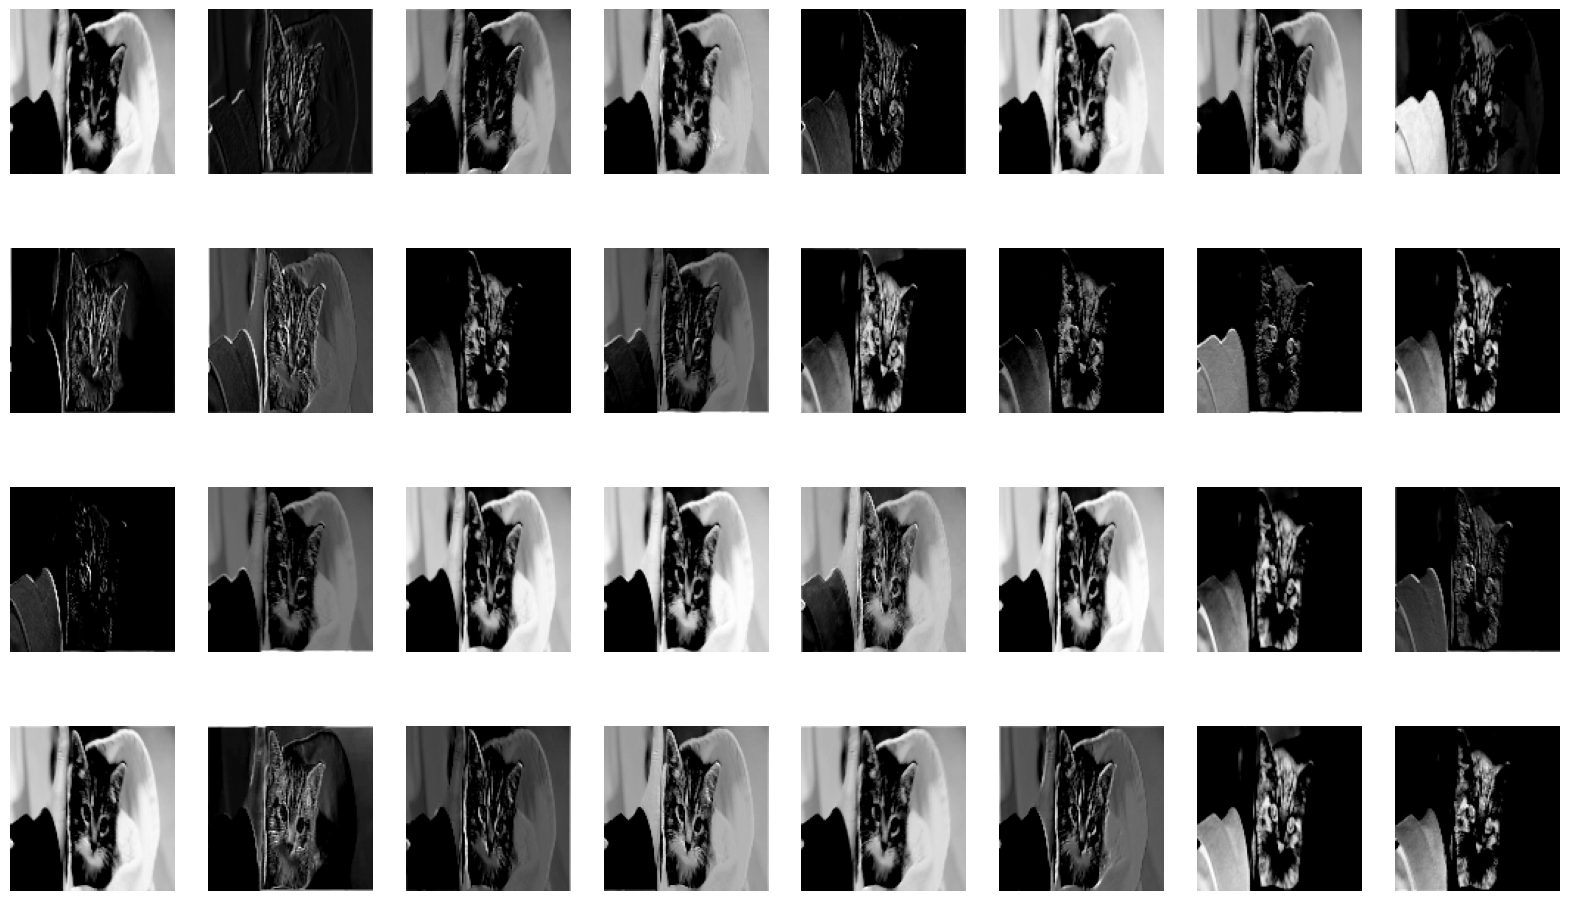

Layer 1 insights:
Each subplot represents a channel (or a 'feature detector') within this layer.
Bright areas in these plots can indicate regions within the input image that activated the corresponding feature detector.
As we progress through layers, the features tend to move from simple edges and textures to more complex patterns specific to the classes (e.g., parts of a cat).
This progression illustrates how CNNs build up an understanding of the image content layer by layer.


Visualizing 64 feature maps for Conv Layer 2


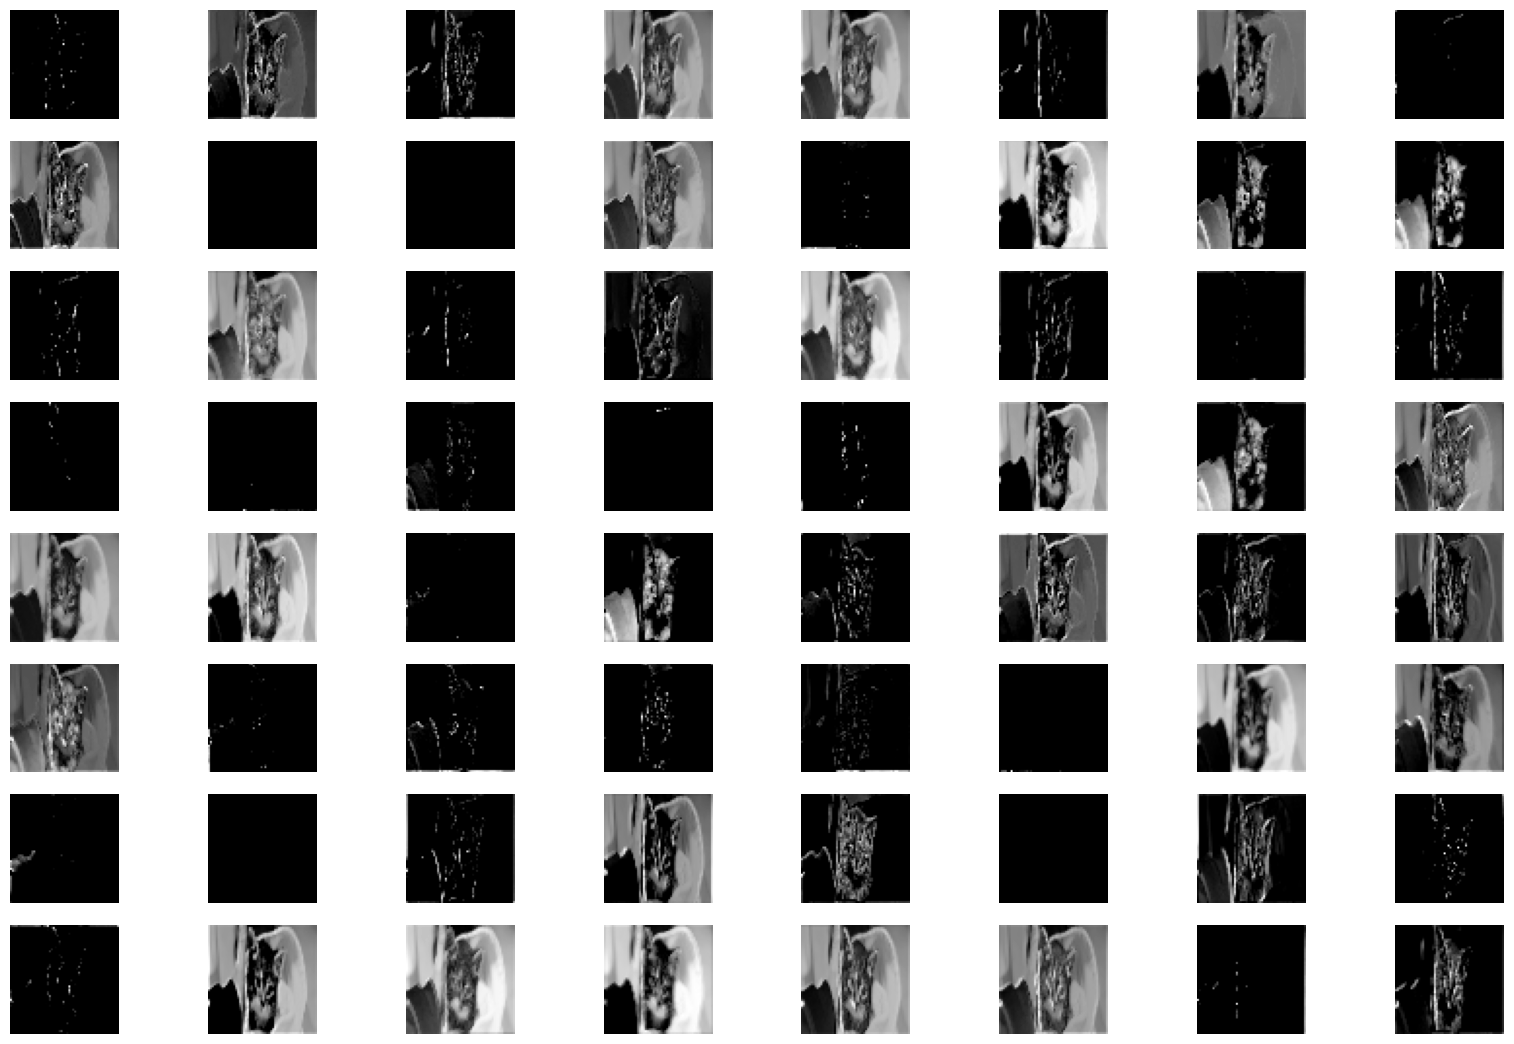

Layer 2 insights:
Each subplot represents a channel (or a 'feature detector') within this layer.
Bright areas in these plots can indicate regions within the input image that activated the corresponding feature detector.
As we progress through layers, the features tend to move from simple edges and textures to more complex patterns specific to the classes (e.g., parts of a cat).
This progression illustrates how CNNs build up an understanding of the image content layer by layer.




In [ ]:
# Assume 'model' is your trained CatOrNotCNN model
# and 'val_loader' is your DataLoader for the validation set

# Turn model to evaluation mode
model.eval()

# Get a single batch of images
images, labels = next(iter(val_loader))

# Move images to the same device as model
images = images.to(next(model.parameters()).device)

# Forward pass to get outputs and feature maps
with torch.no_grad():
    _, feature_maps = model(images)

# Visualize feature maps for the first image in the batch
visualize_feature_maps(feature_maps)
